## Notebook-Dokumentation
- Berechnet Haversine-Distanz zwischen Start/End-Koordinaten und filtert lange Fahrten.
- Zeigt Top-Langstrecken (Tabellen) und deren zeitliche/typ-basierte Muster.
- Einfache Plausibilitätschecks auf fehlerhafte Geokoordinaten.


Lädt Fahrten (2023–2025) mit Schema und Zeitfilter in Lazy-Scan

In [ ]:
from pathlib import Path
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

DATA_DIR = Path("../../raw_data/citi_bike")
FILES = (sorted(DATA_DIR.glob("2023-citibike-tripdata/*.csv")) 
    + sorted(DATA_DIR.glob("2024-citibike-tripdata/*.csv")) 
    + sorted(DATA_DIR.glob("2025-citibike-tripdata/*.csv")))

SCHEMA = {
    "ride_id": pl.Utf8,
    "rideable_type": pl.Utf8,
    "started_at": pl.Datetime,
    "ended_at": pl.Datetime,
    "start_station_name": pl.Utf8,
    "start_station_id": pl.Utf8,
    "end_station_name": pl.Utf8,
    "end_station_id": pl.Utf8,
    "start_lat": pl.Float64,
    "start_lng": pl.Float64,
    "end_lat": pl.Float64,
    "end_lng": pl.Float64,
    "member_casual": pl.Utf8,
}

scan = (
    pl.scan_csv([str(p) for p in FILES], schema=SCHEMA, try_parse_dates=True, ignore_errors=True)
    .filter(
        (pl.col("started_at").dt.year() >= 2023) & (pl.col("started_at").dt.year() <= 2025) &
        (pl.col("ended_at").dt.year() >= 2023) & (pl.col("ended_at").dt.year() <= 2025)
    )
)


Definiert eine Haversine-Expressionsfunktion zur Distanzberechnung in km (keine Ausgabe).

In [7]:
# Define haversine distance expression
EARTH_RADIUS_KM = 6371.0
TO_RAD = np.pi / 180.0


def distance_km_expr():
    lat1 = pl.col("start_lat") * TO_RAD
    lat2 = pl.col("end_lat") * TO_RAD
    dlat = (pl.col("end_lat") - pl.col("start_lat")) * TO_RAD
    dlon = (pl.col("end_lng") - pl.col("start_lng")) * TO_RAD
    a = (dlat / 2).sin() ** 2 + lat1.cos() * lat2.cos() * (dlon / 2).sin() ** 2
    c = (a.sqrt()).arcsin() * 2
    return EARTH_RADIUS_KM * c


Berechnet Distanz, Dauer und Geschwindigkeit, filtert unrealistische Koordinaten/Zeiten/Geschwindigkeiten; Ergebnis ist gefiltertes LazyFrame rides.

In [ ]:
valid = scan.filter(
    pl.col("start_lat").is_between(-90, 90)
    & pl.col("end_lat").is_between(-90, 90)
    & pl.col("start_lng").is_between(-180, 180)
    & pl.col("end_lng").is_between(-180, 180)
)

rides = (
    valid.with_columns(
        distance_km_expr().alias("distance_km"),
        ((pl.col("ended_at") - pl.col("started_at")).dt.total_seconds() / 60).alias("duration_min"),
    )
    .filter((pl.col("duration_min") > 1) & (pl.col("duration_min") < 360))
    .with_columns((pl.col("distance_km") / (pl.col("duration_min") / 60)).alias("speed_kmh"))
    .filter((pl.col("speed_kmh") > 1) & (pl.col("speed_kmh") < 75)) # realistic speed and filter start stations = end stations
)



Ermittelt Distanz-Quantile (p95/p99), Max/Mean und Geschwindigkeitskennzahlen

In [ ]:
distance_stats = rides.select(
    [
        pl.col("distance_km").quantile(0.95).alias("km_p95"),
        pl.col("distance_km").quantile(0.99).alias("km_p99"),
        pl.col("distance_km").max().alias("max_km"),
        pl.col("distance_km").mean().alias("mean_km"),
        pl.col("speed_kmh").median().alias("median_speed_kmh"),
        pl.col("speed_kmh").mean().alias("mean_speed_kmh"),
        pl.col("speed_kmh").quantile(0.95).alias("speed_kmh_p95"),
        pl.col("speed_kmh").quantile(0.99).alias("speed_kmh_p99"),
    ]
).collect()

distance_stats


km_p95,km_p99,max_km,mean_km,median_speed_kmh,mean_speed_kmh,speed_kmh_p95,speed_kmh_p99
f64,f64,f64,f64,f64,f64,f64,f64
5.484283,8.334938,29.906776,2.04523,10.923753,11.061663,17.71692,20.54233


Wie zuvor, aber nach Jahr gruppiert; Tabelle mit Distanz-/Speed-Kennzahlen und Anzahl Fahrten pro Jahr.

In [ ]:
distance_stats_by_year = rides.with_columns(
    pl.col("started_at").dt.year().alias("year")
).group_by("year").agg([
    pl.col("distance_km").quantile(0.95).alias("km_p95"),
    pl.col("distance_km").quantile(0.99).alias("km_p99"),
    pl.col("distance_km").max().alias("max_km"),
    pl.col("distance_km").mean().alias("mean_km"),
    pl.col("speed_kmh").median().alias("median_speed_kmh"),
    pl.col("speed_kmh").mean().alias("mean_speed_kmh"),
    pl.col("speed_kmh").quantile(0.95).alias("speed_kmh_p95"),
    pl.col("speed_kmh").quantile(0.99).alias("speed_kmh_p99"),
    pl.len().alias("total_rides"),
]).sort("year").collect()

distance_stats_by_year

year,km_p95,km_p99,max_km,mean_km,median_speed_kmh,mean_speed_kmh,speed_kmh_p95,speed_kmh_p99,total_rides
i32,f64,f64,f64,f64,f64,f64,f64,f64,u32
2023,5.399438,8.301539,27.735412,1.989087,10.262652,10.486709,17.397594,20.70928,33513682
2024,5.582259,8.457912,29.906776,2.082071,11.081948,11.218174,17.943356,20.704506,42749891
2025,5.446861,8.237858,28.32156,2.052142,11.281838,11.345221,17.687344,20.266504,44357919


Filtert Langstrecken (>=p95) und fasst nach Bike-Typ und Mitgliedschaft zusammen

In [ ]:
p95 = distance_stats["km_p95"][0]

long_rides = rides.filter(pl.col("distance_km") >= p95)

long_summary = (
    long_rides.group_by(["rideable_type", "member_casual"])
    .agg(
        pl.len().alias("rides"),
        pl.mean("distance_km").alias("avg_distance_km"),
        pl.median("distance_km").alias("median_distance_km"),
    )
    .sort("rides", descending=True)
    .collect()
)

long_summary


rideable_type,member_casual,rides,avg_distance_km,median_distance_km
str,str,u32,f64,f64
"""electric_bike""","""member""",3865478,7.340528,6.783285
"""electric_bike""","""casual""",1018656,7.337814,6.708135
"""classic_bike""","""member""",904633,6.960422,6.535016
"""classic_bike""","""casual""",242315,7.043727,6.477736


Wie zuvor, aber nach Jahr gruppiert; erzeugt Balkendiagramm mit Anteilslabels pro Gruppe und Jahr.

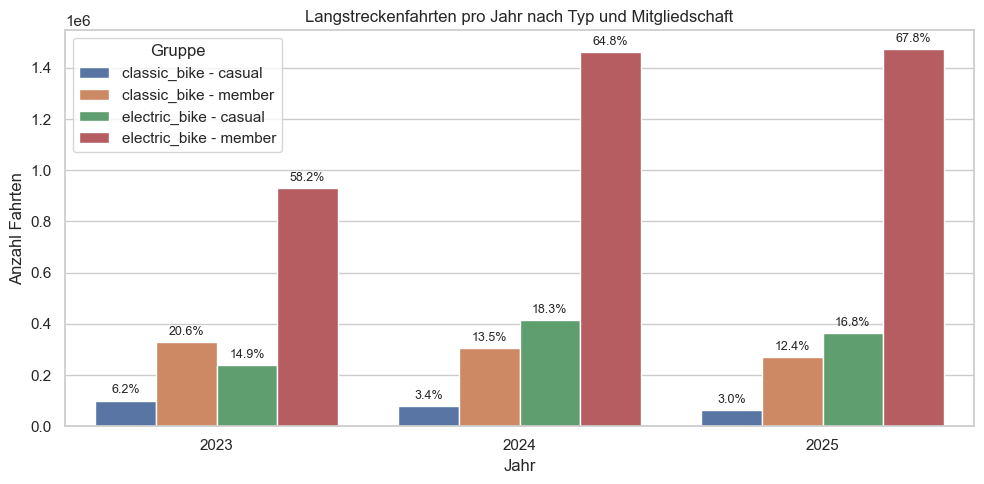

In [ ]:
long_summary_by_year = (
    long_rides.with_columns(pl.col("started_at").dt.year().alias("year"))
    .group_by(["year", "rideable_type", "member_casual"])
    .agg(
        pl.len().alias("rides"),
        pl.col("distance_km").mean().alias("avg_distance_km"),
        pl.col("distance_km").median().alias("median_distance_km"),
    )
    .sort(["year", "rides"], descending=[False, True])
    .collect()
)

pdf = long_summary_by_year.to_pandas()
pdf["group"] = pdf["rideable_type"] + " - " + pdf["member_casual"]

pdf["year_total"] = pdf.groupby("year")["rides"].transform("sum")
pdf["share_pct"] = pdf["rides"] / pdf["year_total"] * 100

x_order = sorted(pdf["year"].unique().tolist())
hue_order = sorted(pdf["group"].unique().tolist())

plt.figure(figsize=(10, 5))
ax = sns.barplot(
    data=pdf,
    x="year",
    y="rides",
    hue="group",
    order=x_order,
    hue_order=hue_order,
    errorbar=None,
)
plt.title("Langstreckenfahrten pro Jahr nach Typ und Mitgliedschaft")
plt.xlabel("Jahr")
plt.ylabel("Anzahl Fahrten")
plt.legend(title="Gruppe")

labels = []
lookup = {(int(r.year), r.group): r.share_pct for r in pdf.itertuples(index=False)}
for h in hue_order:
    for x in x_order:
        pct = lookup.get((int(x), h))
        labels.append(f"{pct:.1f}%" if pct is not None else "")

for bar, label in zip(ax.patches, labels):
    height = bar.get_height()
    ax.annotate(
        label,
        (bar.get_x() + bar.get_width() / 2.0, height),
        ha="center",
        va="bottom",
        fontsize=9,
        xytext=(0, 3),
        textcoords="offset points",
    )

plt.tight_layout()
plt.show()

Listet die Top 20 längsten Fahrten mit Metadaten, Dauer, Speed

In [ ]:
longest = (
    long_rides.select(
        [
            "ride_id",
            "rideable_type",
            "member_casual",
            "start_station_name",
            "end_station_name",
            "distance_km",
            "duration_min",
            "speed_kmh",
        ]
    )
    .sort("distance_km", descending=True)
    .limit(20)
    .collect()
)

longest


ride_id,rideable_type,member_casual,start_station_name,end_station_name,distance_km,duration_min,speed_kmh
str,str,str,str,str,f64,f64,f64
"""60DAFA2CB393ACDB""","""classic_bike""","""member""","""67 St & Erik Pl""","""Van Cortlandt Park S & Gouvern…",29.906776,235.316667,7.625497
"""6D368DCB6F349913""","""classic_bike""","""casual""","""67 St & Erik Pl""","""Van Cortlandt Park S & Gouvern…",29.906776,234.983333,7.636314
"""85955781ED7BF624""","""classic_bike""","""member""","""67 St & Erik Pl""","""Van Cortlandt Park S & Gouvern…",29.906776,234.533333,7.650966
"""32145C4DCC78EF4D""","""electric_bike""","""member""","""Jerome Ave & E Mosholu Pkwy S""","""53 St & 5 Ave""",28.32156,94.033333,18.071183
"""CFD2AF4A8356CE12""","""electric_bike""","""member""","""Broadway & W 234 St""","""53 St & 5 Ave""",28.06101,169.066667,9.95856
…,…,…,…,…,…,…,…
"""23BA22A02499FD5A""","""electric_bike""","""member""","""E Mosholu Pkwy & Van Cortlandt…","""Albemarle Rd & McDonald Ave""",26.980629,102.083333,15.858002
"""751D3E4F7FB4031F""","""electric_bike""","""casual""","""58 St & Pier 4""","""Broadway & W 220 St""",26.873579,110.666667,14.570013
"""B5B5612471B2AE5E""","""electric_bike""","""member""","""Goulden Ave & Bedford Park Blv…","""Church Ave & Story St""",26.771795,96.266667,16.686022


Histogramm der Distanzverteilung aller bereinigten Fahrten.

Text(0, 0.5, 'rides')

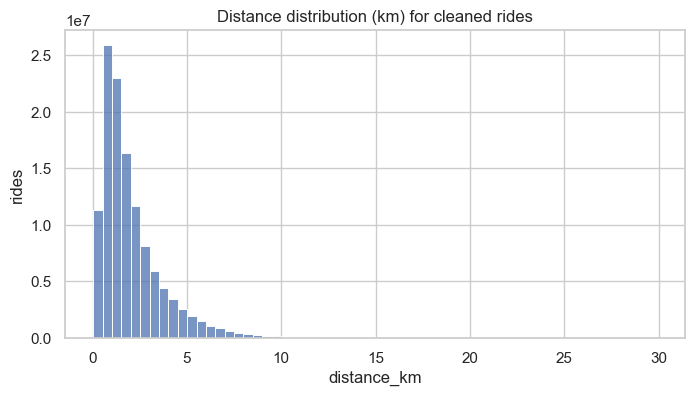

In [ ]:
sample = rides.select(pl.col("distance_km")).collect().to_pandas()

plt.figure(figsize=(8, 4))
sns.histplot(sample["distance_km"], bins=60)
plt.title("Distance distribution (km) for cleaned rides")
plt.xlabel("distance_km")
plt.ylabel("rides")


Histogramm der Distanzverteilung nach Jahr (Dichte, farblich nach Jahr) als Vergleich der Jahre.

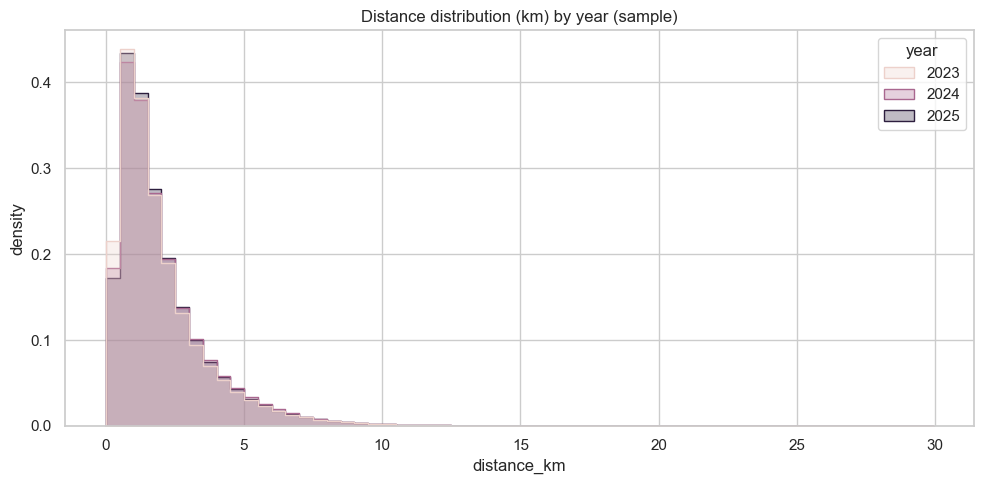

: 

In [ ]:
sample_by_year = (
    rides.with_columns(pl.col("started_at").dt.year().alias("year"))
         .select(["year", "distance_km"])
         .collect()
         .to_pandas()
)

plt.figure(figsize=(10, 5))
sns.histplot(
    data=sample_by_year,
    x="distance_km",
    hue="year",
    hue_order=x_order,
    bins=60,
    stat="density",
    common_norm=False,
    element="step",
    alpha=0.3,
)
plt.title("Distance distribution (km) by year (sample)")
plt.xlabel("distance_km")
plt.ylabel("density")
plt.tight_layout()
plt.show()